In [1]:
import torch
from torch import tensor
from torch.types import Tensor
from math import *

# Disable JIT compiler and profiling for better debugging
# torch._C._jit_set_profiling_executor(False)
# torch._C._jit_set_profiling_mode(False)
# torch.jit._state.disable()


# Refactoring Goals
- Remove confusion between numpy and torch vectorisations
- Use builtin maths for scalars
- Use torch.tensor for everything else
- Tighten up the data type headaches
- Remove sliding NSGT support
- De-crustify the legacy code
- Make the pytorch code more idiomatic



In [2]:
class Scale:
    dbnd = 1.e-8
    
    F : Tensor = None
    Q : Tensor = None

    def F_by_bnd(self, bnd_index: Tensor):
        return self.F[bnd_index]
    
    def Q_by_bnd(self, bnd_index: Tensor):
        return self.Q[bnd_index]

    def __init__(self, bnds):
        self.bnds = bnds

    def __len__(self):
        return self.bnds

class OctScale(Scale):
    def __init__(self, bpo, fmin, fmax, beyond=0):
        """
        @param fmin: minimum frequency (Hz)
        @param fmax: maximum frequency (Hz)
        @param bpo: bands per octave (int)
        @param beyond: number of frequency bands below fmin and above fmax (int)
        """
        lfmin = log2(fmin)
        lfmax = log2(fmax)
        bnds = int(ceil((lfmax-lfmin)*bpo))+1
        Scale.__init__(self, bnds+beyond*2)
        odiv = (lfmax-lfmin)/(bnds-1)
        lfmin_ = lfmin-odiv*beyond
        lfmax_ = lfmax+odiv*beyond
        self.fmin = 2**lfmin_
        self.fmax = 2**lfmax_
        self.pow2n = 2**odiv
        q = sqrt(self.pow2n)/(self.pow2n-1.)/2.
        self.n_b = bpo

        self.Q = tensor([q])
        self.F = self.fmin*self.pow2n**torch.arange(self.bnds)



class LinScale(Scale):
    def __init__(self, bnds, fmin, fmax, beyond=0):
        """
        @param fmin: minimum frequency (Hz)
        @param fmax: maximum frequency (Hz)
        @param bnds: number of frequency bands (int)
        @param beyond: number of frequency bands below fmin and above fmax (int)
        """
        self.df = float(fmax-fmin)/(bnds-1)
        Scale.__init__(self, bnds+beyond*2)
        self.fmin = float(fmin)-self.df*beyond
        if self.fmin <= 0:
            raise ValueError("Frequencies must be > 0.")
        self.fmax = float(fmax)+self.df*beyond
        self.n_b = bnds

        self.F = torch.arange(self.bnds)*self.df+self.fmin
        self.Q = self.F / (self.df*2)


def hz2mel(f):
    "\\cite{shannon:2003}"
    if isinstance(f, Tensor):
        return torch.log10(f/700.+1.)*2595.
    else:
        return log10(f/700.+1.)*2595


def mel2hz(m):
    "\\cite{shannon:2003}"
    return (10.0**(m/2595.)-1)*700


class MelScale(Scale):
    def __init__(self, bnds, fmin, fmax, beyond=0):
        """
        @param fmin: minimum frequency (Hz)
        @param fmax: maximum frequency (Hz)
        @param bnds: number of frequency bands (int)
        @param beyond: number of frequency bands below fmin and above fmax (int)
        """
        mmin = hz2mel(fmin)
        mmax = hz2mel(fmax)
        Scale.__init__(self, bnds+beyond*2)
        self.fmin = float(fmin)
        self.fmax = float(fmax)
        self.mbnd = (mmax-mmin)/(bnds-1)  # mels per band
        self.mmin = mmin-self.mbnd*beyond
        self.mmax = mmax+self.mbnd*beyond
        self.n_b = bnds

        mels = torch.arange(bnds) * self.mbnd + self.mmin

        self.F = mel2hz(mels)

        odivs = (torch.exp(mels/-1127.)-1.) * (-781.177/self.mbnd)
        pow2n = 2.0 ** (1./odivs)
        self.Q = pow2n.sqrt()/ (pow2n-1.)/2.
    


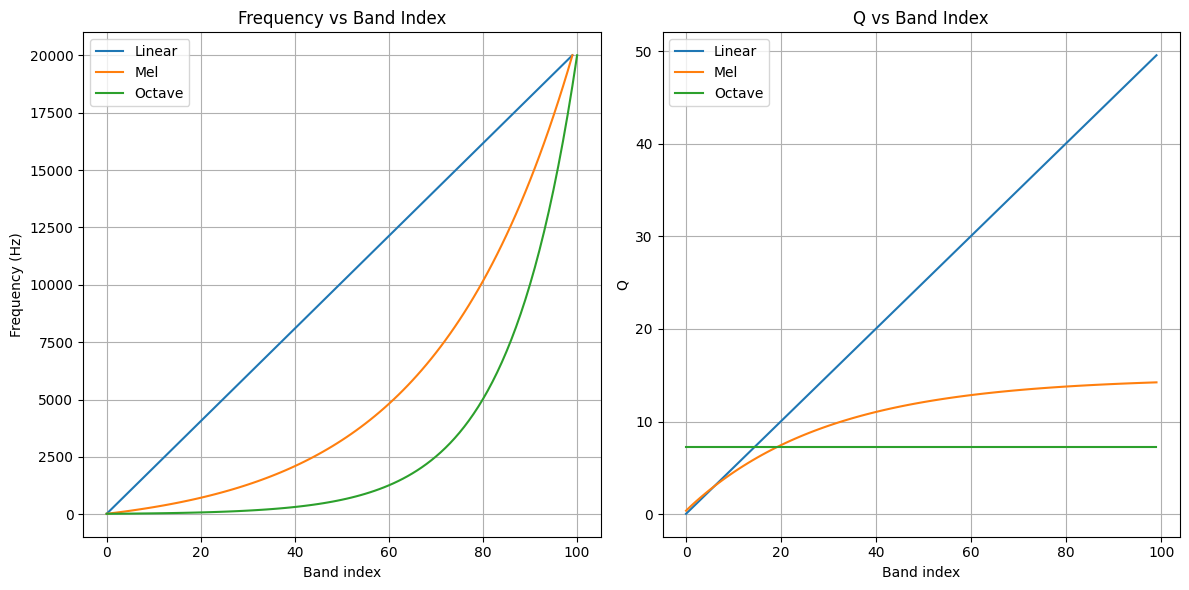

In [3]:
import matplotlib.pyplot as plt

# Create example scales
lin_scale = LinScale(100, 20, 20000)
mel_scale = MelScale(100, 20, 20000)
oct_scale = OctScale(10,  20, 20000)

# Plot frequency scales
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(lin_scale.F, label='Linear')
plt.plot(mel_scale.F, label='Mel')
plt.plot(oct_scale.F, label='Octave')
plt.xlabel('Band index')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency vs Band Index')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(lin_scale.Q, label='Linear')
plt.plot(mel_scale.Q, label='Mel')
plt.plot(oct_scale.Q.repeat(100), label='Octave')
plt.xlabel('Band index')
plt.ylabel('Q')
plt.title('Q vs Band Index')
plt.legend()
plt.grid(True)



plt.tight_layout()
plt.show()


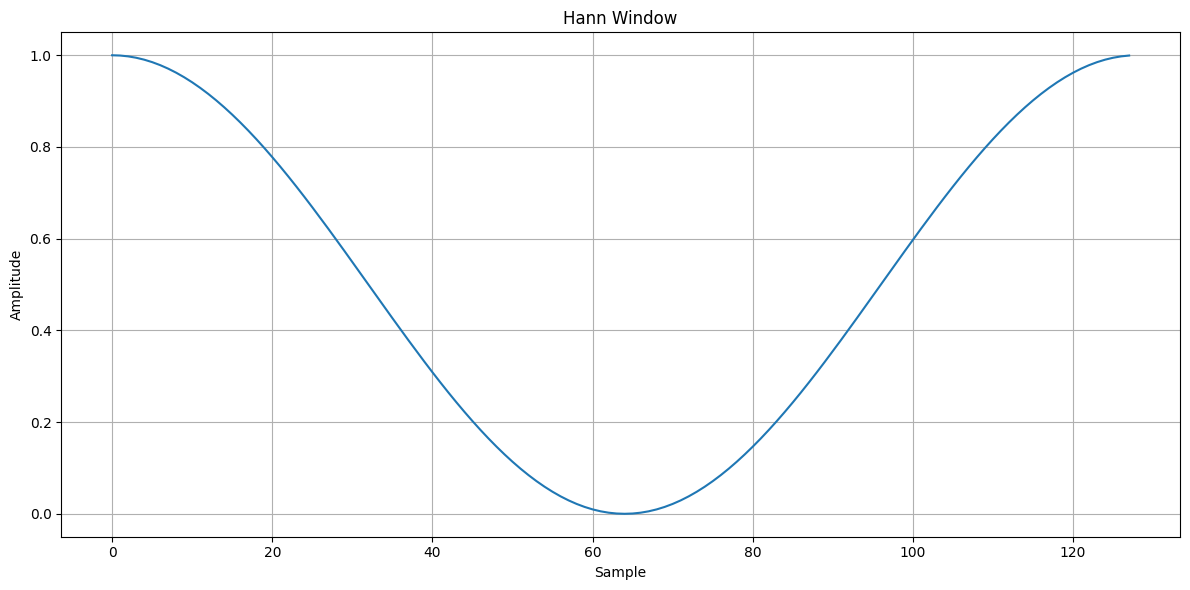

In [4]:
def hannwin(l):
    r = torch.arange(l,dtype=float)
    r *= torch.pi*2./l
    r = torch.cos(r)
    r += 1.
    r *= 0.5
    return r


# Plot Hann window
plt.figure(figsize=(12, 6))
hann_window = hannwin(128)  # Create 128-sample Hann window
plt.plot(hann_window.cpu().numpy())  # Convert to numpy for plotting
plt.title('Hann Window')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
from warnings import warn

"""
Thomas Grill, 2011-2015
http://grrrr.org/nsgt

--
        Original matlab code comments follow:

NSGFWIN.M
---------------------------------------------------------------
 [g,rfbas,M]=nsgfwin(fmin,bins,sr,Ls) creates a set of windows whose
 centers correspond to center frequencies to be
 used for the nonstationary Gabor transform with varying Q-factor. 
---------------------------------------------------------------

INPUT : fmin ...... Minimum frequency (in Hz)
        bins ...... Vector consisting of the number of bins per octave
        sr ........ Sampling rate (in Hz)
        Ls ........ Length of signal (in samples)

OUTPUT : g ......... Cell array of window functions.
         rfbas ..... Vector of positions of the center frequencies.
         M ......... Vector of lengths of the window functions.

AUTHOR(s) : Monika Dörfler, Gino Angelo Velasco, Nicki Holighaus, 2010

COPYRIGHT : (c) NUHAG, Dept.Math., University of Vienna, AUSTRIA
http://nuhag.eu/
Permission is granted to modify and re-distribute this
code in any manner as long as this notice is preserved.
All standard disclaimers apply.

EXTERNALS : firwin
"""

def nsgfwin(f : Tensor, q: Tensor, sr, Ls, min_win=4, do_warn=True) -> tuple[list, Tensor, Tensor]:
    """
    f: list of center frequencies
    q: list of Q-factors
    sr: sampling rate
    Ls: length of signal
    min_win: minimum window length

    Returns:
        g: list of window functions
        rfbas: list of center frequencies
        M: list of window lengths
    """

    nyquist_f = sr/2.0

    mask = f > 0
    lim = torch.argmax(mask.int())
    if mask.any():
        # f partly <= 0 
        f = f[lim:]
        q = q[lim:]
            
    mask = f >= nyquist_f
    lim = torch.argmax(mask.int())
    if mask.any():
        # f partly >= nf 
        f = f[:lim]
        q = q[:lim]
    
    # assert len(f) == len(q)
    assert torch.all((f[1:]-f[:-1]) > 0)  # frequencies must be monotonic
    assert torch.all(q > 0)  # all q must be > 0
    
    qneeded = f*(Ls/(8.*sr))
    if torch.any(q >= qneeded) and do_warn:
        warn("Q-factor too high for frequencies %s"%",".join("%.2f"%fi for fi in f[q >= qneeded]))
    
    fbas : Tensor[int] = f
    lbas : int = len(fbas)
    frqs = torch.concatenate([
        tensor([0.0])
        ,f,
        tensor([nyquist_f])
    ])
    fbas = torch.concatenate([frqs, tensor([sr]) - torch.flip(f, (0,))])

    fbas *= float(Ls)/sr

    M : Tensor = torch.zeros(fbas.shape, dtype=int)

    M[0] = torch.round(2*fbas[1])
    for k in range(1,2*lbas+1):
        M[k] = torch.round(fbas[k+1]-fbas[k-1])
    M[-1] = torch.round(Ls-fbas[-2])

    M = torch.clip(M, min_win, torch.inf).to(int)

    g : list = [hannwin(m) for m in M]

    fbas[lbas] = (fbas[lbas-1]+fbas[lbas+1])/2
    fbas[lbas+2] = Ls-fbas[lbas]
    rfbas = torch.round(fbas).to(int)

    return g, rfbas, M

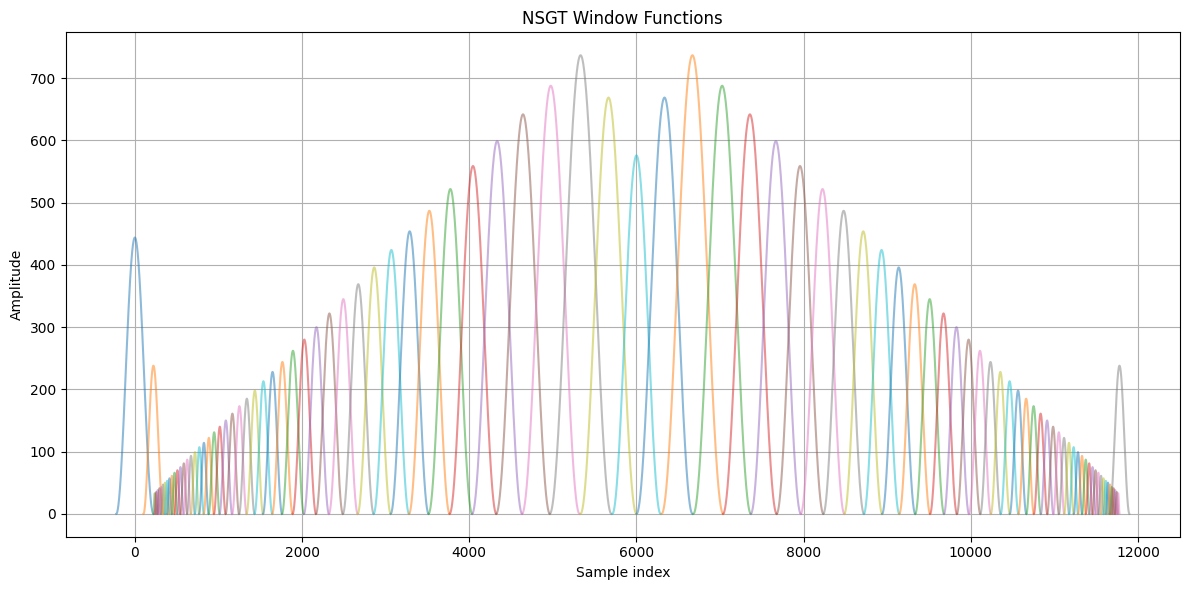

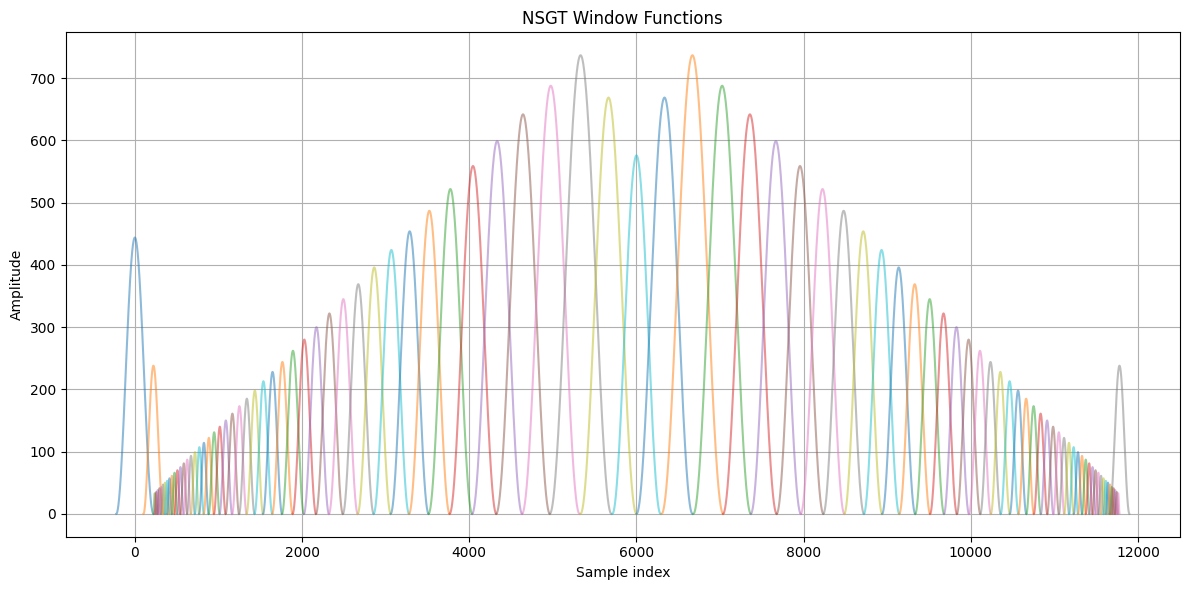

In [6]:
f = oct_scale.F
q = oct_scale.Q

sr = 1080
Ls = 12000

g, rfbas, M = nsgfwin(f,q,sr,Ls)

def plot_nsgfwin_results(g, rfbas, M):
    fig, ax = plt.subplots(figsize=(12,6))
    
    # Plot each window function
    for i, window in enumerate(g):
        # Center each window at its frequency position
        center = rfbas[i]
        x = torch.arange(len(window)) + center - len(window)//2
        ax.plot(x, M[i]- window * M[i], alpha=0.5, label=f'Window {i}')
    
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Amplitude') 
    ax.set_title('NSGT Window Functions')
    ax.grid(True)
    
    # Only show legend if there aren't too many windows
    if len(g) <= 10:
        ax.legend()
        
    plt.tight_layout()
    return fig

# Test the plotting function
plot_nsgfwin_results(g, rfbas, M)

NN:  12000


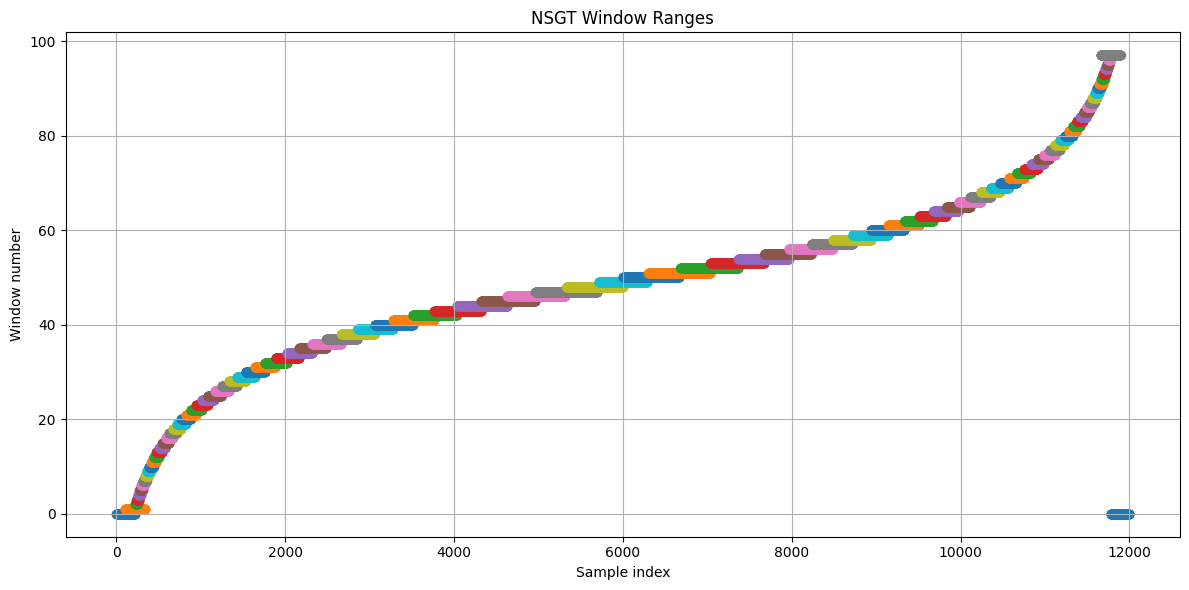

In [7]:
def calcwinrange(g : list, rfbas : Tensor, Ls : int) -> tuple[list[Tensor], int]:
    shift = torch.concatenate([
        (-rfbas[-1] % Ls).unsqueeze(0), 
        rfbas[1:]-rfbas[:-1]
    ])
    
    timepos = torch.cumsum(shift, 0)
    nn = int(timepos[-1].item())
    timepos -= shift[0] # Calculate positions from shift vector
    
    wins = []
    for gii,tpii in zip(g, timepos):
        Lg = len(gii)
        win_range = torch.arange(-(Lg//2)+tpii, Lg-(Lg//2)+tpii, dtype=int)
        win_range %= nn

        wins.append(win_range)
        
    return wins,nn


#================

# Plot the window ranges
wins, nn = calcwinrange(g, rfbas, Ls)

print ("NN: ", nn)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each window range as a scatter plot
for i, win_range in enumerate(wins):
    ax.scatter(win_range.cpu(), [i] * len(win_range), alpha=0.5, label=f'Window {i}')

ax.set_xlabel('Sample index')
ax.set_ylabel('Window number')
ax.set_title('NSGT Window Ranges')
ax.grid(True)

# Only show legend if there aren't too many windows
if len(wins) <= 10:
    ax.legend()
    
plt.tight_layout()
plt.show()


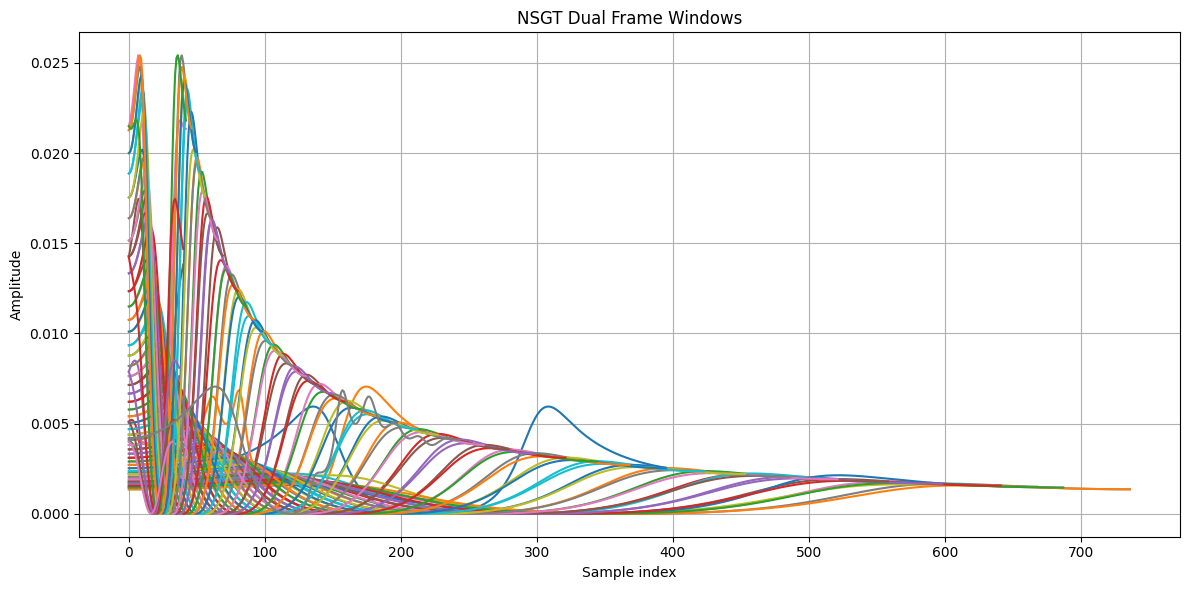

In [8]:
def nsdual(g: list[Tensor], wins: list[Tensor], nn: Tensor, M: list[int]) -> list[Tensor]:
    # Construct the diagonal of the frame operator matrix explicitly
    x = torch.zeros(nn, dtype=float)
    for gi,mii,sl in zip(g, M, wins):
        xa = torch.square(torch.fft.fftshift(gi))
        xa *= mii

        x[sl] += xa

    gd = [gi/torch.fft.ifftshift(x[wi]) for gi,wi in zip(g,wins)]
    return gd

# Calculate dual frame
gd = nsdual(g, wins, nn, M)

# Plot the dual frame
fig, ax = plt.subplots(figsize=(12, 6))

for i, gdii in enumerate(gd):
    ax.plot(gdii, label=f'Dual Window {i}')

ax.set_xlabel('Sample index')
ax.set_ylabel('Amplitude')
ax.set_title('NSGT Dual Frame Windows')
ax.grid(True)

# Only show legend if there aren't too many windows
if len(gd) <= 10:
    ax.legend()
    
plt.tight_layout()
plt.show()


# [win.shape[0] for win in gd]


In [9]:
def n_coefs(M: Tensor, g: list[Tensor], sl: slice)->int:
    return int(max(int(ceil(float(len(gii))/mii))*mii for mii,gii in zip(M[sl],g[sl])).item())

n_coefs(M, g, slice(0,50))

737

In [10]:
# Save dual windows to file
print(gd)


[tensor([2.2523e-03, 2.2524e-03, 2.2527e-03, 2.2533e-03, 2.2541e-03, 2.2551e-03,
        2.2563e-03, 2.2578e-03, 2.2595e-03, 2.2614e-03, 2.2636e-03, 2.2660e-03,
        2.2686e-03, 2.2714e-03, 2.2745e-03, 2.2778e-03, 2.2814e-03, 2.2852e-03,
        2.2892e-03, 2.2935e-03, 2.2980e-03, 2.3027e-03, 2.3077e-03, 2.3130e-03,
        2.3185e-03, 2.3242e-03, 2.3302e-03, 2.3365e-03, 2.3430e-03, 2.3498e-03,
        2.3569e-03, 2.3642e-03, 2.3718e-03, 2.3797e-03, 2.3878e-03, 2.3962e-03,
        2.4049e-03, 2.4140e-03, 2.4233e-03, 2.4329e-03, 2.4428e-03, 2.4530e-03,
        2.4635e-03, 2.4743e-03, 2.4855e-03, 2.4970e-03, 2.5088e-03, 2.5209e-03,
        2.5334e-03, 2.5463e-03, 2.5595e-03, 2.5730e-03, 2.5869e-03, 2.6012e-03,
        2.6159e-03, 2.6310e-03, 2.6465e-03, 2.6623e-03, 2.6786e-03, 2.6953e-03,
        2.7125e-03, 2.7300e-03, 2.7480e-03, 2.7665e-03, 2.7855e-03, 2.8049e-03,
        2.8248e-03, 2.8452e-03, 2.8661e-03, 2.8875e-03, 2.9095e-03, 2.9320e-03,
        2.9551e-03, 2.9788e-03, 3.0030e

In [11]:
def nsgtf(
        f: Tensor,
        g: list[Tensor],
        wins: list[Tensor],
        nn: int, M: Tensor,
        reducedform: int
    ) -> Tensor:
    """
    Compute the Non-Stationary Gabor Transform (NSGT) of the input signal.

    This function applies the fast Fourier transform (FFT) to the input signal to convert it into the
    frequency domain. It then processes each frequency slice by multiplying with a corresponding analysis
    window (after necessary padding and FFT shift) and finally applies an inverse FFT to obtain the
    NSGT coefficients representing the signal in the time-frequency domain.

    Parameters:
        f (Tensor): Input signal tensor of shape (channel, signal_length) representing time-domain data.
        g (list[Tensor]): List of analysis window tensors.
        wins (list[Tensor]): List of window ranges (or index arrays) specifying the frequency bins to process for each window.
        nn (int): Total number of samples in the input signal (should match f's last dimension).
        M (Tensor): Tensor containing modulation parameters (e.g., window lengths or hop sizes) for each analysis window.
        reducedform (int): Specifies the level of frequency reduction for real signals (valid values are typically 0, 1, or 2).

    Returns:
        Tensor: 

    Notes:
        - Each analysis window in g is padded to a uniform length based on the maximum number of coefficients required.
        - An FFT shift is applied to the windowed data prior to the inverse FFT to ensure proper alignment.
    """

    fft : function = torch.fft.fft
    ifft : function = torch.fft.ifft

    assert 0 <= reducedform <= 2
    sl = slice(reducedform,len(g)//2+1-reducedform)

    maxLg = int(max(int(ceil(float(len(gii))/mii))*mii for mii,gii in zip(M[sl],g[sl])))

    loopparams = []
    for mii, gii, win_range in zip(M[sl],g[sl],wins[sl]):
        Lg = len(gii)
        col = int(ceil(float(Lg)/mii))
        assert col*mii >= Lg
        assert col == 1

        p = (mii,win_range,Lg,col)
        loopparams.append(p)

    ragged_giis = [
        torch.nn.functional.pad(
            torch.unsqueeze(gii, dim=0), (0, maxLg-gii.shape[0])
        )
            for gii in g[sl]
    ]
    giis = torch.conj(torch.cat(ragged_giis))

    ft = fft(f)

    Ls = f.shape[-1]

    assert nn == Ls

    c = torch.zeros(f.shape[0], len(loopparams), maxLg, dtype=ft.dtype)

    for j, (mii,win_range,Lg,col) in enumerate(loopparams):
        t = ft[:, win_range]*torch.fft.fftshift(giis[j, :Lg])

        sl1 = slice(None,(Lg+1)//2)
        sl2 = slice(-(Lg//2),None)

        c[:, j, sl1] = t[:, Lg//2:]  # if mii is odd, this is of length mii-mii//2
        c[:, j, sl2] = t[:, :Lg//2]  # if mii is odd, this is of length mii//2

    return ifft(c)

from itertools import chain

def nsigtf(
        c: Tensor,
        gd: list[Tensor],
        wins: list[Tensor],
        nn: int,
        Ls: int,
        reducedform: int
    ) -> Tensor:
    fft : function = torch.fft.fft
    ifft : function = torch.fft.irfft

    if reducedform:
        sl = lambda x: chain(
            x[reducedform            : len(gd)//2+1-reducedform],
            x[len(gd)//2+reducedform :    len(gd)+1-reducedform]
        )
    else:
        sl = lambda x: x
    
    maxLg = int(max(len(gdii) for gdii in sl(gd)))

    ragged_gdiis = [
        torch.nn.functional.pad(
            torch.unsqueeze(gdii, dim=0), (0, maxLg-gdii.shape[0])
        )
              for gdii in sl(gd)
    ]
    gdiis = torch.conj(torch.cat(ragged_gdiis))

    assert type(c) == Tensor
    c_dtype = c.dtype
    fc = fft(c)

    fr = torch.zeros(c.shape[0], nn, dtype=c_dtype)  # Allocate output
    temp0 = torch.empty(c.shape[0], maxLg, dtype=fr.dtype)  # pre-allocation

    fbins = c.shape[1]
    loopparams = []
    for gdii,win_range in zip(sl(gd), sl(wins)):
        Lg = len(gdii)
        wr1 = win_range[:(Lg)//2]
        wr2 = win_range[-((Lg+1)//2):]
        p = (wr1,wr2,Lg)
        loopparams.append(p)

    # Overlapp-add procedure
    for i,(wr1,wr2,Lg) in enumerate(loopparams[:fbins]):
        t = fc[:, i]

        r = (Lg+1)//2
        l = (Lg//2)

        t1 = temp0[:, :r]
        t2 = temp0[:, Lg-l:Lg]

        t1[:, :] = t[:, :r]
        t2[:, :] = t[:, maxLg-l:maxLg]

        temp0[:, :Lg] *= gdiis[i, :Lg]
        temp0[:, :Lg] *= maxLg

        fr[:, wr1] += t2
        fr[:, wr2] += t1

    ftr = fr[:, :nn//2+1]
    sig = ifft(ftr, n=nn) ### NEED TO FIX!!!
    sig = sig[:, :Ls] # Truncate the signal to original length (if given)
    return sig


# Stereo Encoding: Interaural Ratio

In [12]:
def interaural(c: Tensor, significance_threshold = 4.0):
    """
    Computes an interaural ratio spectrogram with the centre signal cancelled.

    Args:
        c (Tensor): Complex spectrogram tensor with shape [channels, frequency, time]
                    where channels should be 2 (left and right)
        significance_threshold (float, optional): Threshold to filter out extreme ratio values.
                Values with magnitude above this threshold will be set to zero. Defaults to 4.0.
    
    Returns:
        Tensor: Interaural ratio spectrogram (right/left) with extreme values filtered out.
               Values represent the ratio between right and left channels.
    """
    ## TODO Use the log coefficients (dB)
    c_L,c_R = c
    # (Deleforge, Horoaud 2012) method for computing interaural spectrograms
    # 2D sound source localisation on the binaural manifold
    c_I = c_R / c_L
    return torch.nan_to_num(c_I) # Replace 0-division with the largest ratio storable


def lr_from_interaural(c_centre: Tensor, c_I: Tensor):
    """
    Computes from the interaural ratio a spectrogram from the centre signal.
    Args:
        c_centre (Tensor): Complex spectrogram tensor of the centre signal with shape [frequency, time].
        c_I (Tensor): Interaural ratio spectrogram tensor with shape [frequency, time].
    
    Returns:
        Tensor: Complex spectrogram tensor with shape [channels, frequency, time] where channels are left and right.
    """
    if c_I == None:
        c_I = tensor([0])

    P_L = 2 / (c_I + 1)
    P_R = 2 * c_I / (c_I + 1)

    c_lr = torch.stack((c_centre * P_L, c_centre * P_R), dim=0)
    
    assert not torch.any(c_lr.isnan())
    return c_lr


c = torch.rand(2,4,4,dtype = torch.complex64)

c_mid = c.mean(0)

I = interaural(c)


c_r = lr_from_interaural(c_mid, I)
assert torch.allclose(c, c_r)

In [58]:
import torchvision as tv

from enum import Enum
from tifffile import imread, imwrite, TiffFile
from dataclasses import dataclass, field
import json


Oct = 0
Mel = 1
Lin = 2
    

@dataclass
class GaborSystemParams:
    scale: int
    n_b: int
    fmin: int
    fmax: int

    fs: int
    Ls: int

    reducedform: int

    @classmethod
    def from_json(cls, json_string: str):
        data = json.loads(json_string)
        return cls(**data)

@dataclass
class GaborSystem:
    params: GaborSystemParams
    
    ncoefs: int
    nn : int
    M: Tensor
    g: list[Tensor]
    gd: list[Tensor]

    wins: list[Tensor]

    @classmethod
    def from_params(cls, gs : GaborSystemParams):
        """
        Create a GaborSystem from a scale, sample rate, and signal length.
        
        Args:
            scale (Scale): The frequency scale to use (e.g., OctScale)
            fs (int): Sample rate in Hz
            Ls (int): Length of the signal in samples
            reducedform (bool, optional): Whether to use reduced form. Defaults to True.
            
        Returns:
            GaborSystem: A fully initialized GaborSystem object
        """
        if gs.scale == Oct:
            scale = OctScale(gs.n_b, gs.fmin, gs.fmax)
        elif gs.scale == Mel:
            scale = MelScale(gs.n_b, gs.fmin, gs.fmax)
        elif gs.scale == Lin:
            scale = LinScale(gs.n_b, gs.fmin, gs.fmax)

        g, rfbas, M = nsgfwin(scale.F, scale.Q, gs.fs, gs.Ls)

        assert 0 <= gs.reducedform <= 2
        sl = slice(gs.reducedform,len(g)//2+1-gs.reducedform)

        _n_coefs = n_coefs(M, g, sl)

        if gs.reducedform:
            rm = M[gs.reducedform:len(M)//2+1-gs.reducedform]
            M[:] = rm.max()
        else:
            M[:] = M.max()

        wins, nn = calcwinrange(g, rfbas, gs.Ls)
        gd = nsdual(g, wins, nn, M)
        # Set up the Gabor system
        return cls(gs, _n_coefs, nn, M, g, gd, wins)
        

        

def c_to_tiff(c: Tensor, filename: str, gs: GaborSystem, gamma: float, normalize: bool = True) -> None:
    """
    Encode a complex spectrogram tensor as a multi-page TIFF file.
    
    Args:
        c (Tensor): Complex spectrogram tensor [channels, bins, frames]
        filename (str): Output filename for the TIFF file
        normalize (bool, optional): Whether to normalize magnitude values to [0,1]. Defaults to True.
    
    The TIFF file will contain:
        - Page 0: Magnitude spectrogram
        - Page 1: Phase spectrogram (in radians, scaled to [0,1])
    """
    # Ensure the input is on CPU and convert to numpy
    c = c.squeeze()
    # c = torch.log1p(c)
    c = c.cpu()
    
    # Extract magnitude and phase
    magnitude = torch.abs(c)
    phase = torch.angle(c)  # -> [-π, π]
    
    # Normalize if requested
    if normalize:
        # Normalize magnitude to [0,1]
        max_mag = magnitude.max()
        magnitude = magnitude / max_mag
        
        # [-π, π] -> [0,1]
        phase = (phase + torch.pi) / (2 * torch.pi)
    
    # Stack the magnitude and phase as separate pages
    # Convert to float32 for better compatibility
    tiff_data = torch.stack([magnitude, phase], dim=0).float().flip(1)
    print(tiff_data.shape)
    
    # Convert to numpy for tifffile
    tiff_data_np = tiff_data.numpy()

    metadata = {
        "GaborSystem": gs.params.__dict__,
        "normalcoef": max_mag.item() if normalize else 1.0,
        "gamma": gamma,
        "description": "Greyscale complex NSGT spectrogram encoded as magnitude and phase pages.",
        # add additional GaborSystem object fields if desired
    }
    metadata_json = json.dumps(metadata)
    
    # Write to TIFF file with metadata in the ImageDescription tag
    imwrite(filename, tiff_data_np, photometric='minisblack', description=metadata_json)
    print(f"Saved complex spectrogram to {filename} with {tiff_data_np.shape} shape")


def c_from_tiff(filename: str, gamma: float, denormalization_constant: float = None) -> Tensor:
    """
    Decode a complex spectrogram from a multi-page TIFF file.
    
    Args:
        filename (str): Input TIFF filename
        denormalize (bool, optional): Whether to denormalize values. Defaults to True.
    
    Returns:
        Tensor: Complex spectrogram tensor [channels, bins, frames]
    """
    # Read the TIFF file
    c = torch.tensor(imread(filename))
    # c = torch.expm1(c)
    print("Importing tiff c with shape: ", c.shape)
    magnitude, phase = c.flip(1)
    print(magnitude.shape)
    
    #
    # Denormalize if requested
    if denormalization_constant is not None:
        magnitude = magnitude * denormalization_constant
        # Denormalize phase from [0,1] to [-π, π]
        phase = phase * (2 * torch.pi) - torch.pi
        # Magnitude is handled by from_log
    
    # Reconstruct complex spectrogram
    real = magnitude * torch.cos(phase)
    imag = magnitude * torch.sin(phase)
    
    # Create complex tensor
    c = torch.complex(real, imag)
    # add channel dim
    # c = c.unsqueeze(0)
    return c




In [28]:
import torchaudio as ta
from IPython.display import display, Audio

@dataclass
class NSGData:
    sourcefile: str
    stereo: bool
    GS: GaborSystem
    
    c: Tensor
    s: Tensor

    @classmethod
    def from_wav(cls, filepath: str, params: GaborSystemParams):
        s, fs = ta.load(filepath)
        Ls = s.shape[-1]
        params.Ls = Ls
        params.fs = fs

        gs = GaborSystem.from_params(params)

        c = nsgtf(s, gs.g, gs.wins, gs.nn, gs.M, gs.params.reducedform)
        stereo = c.shape[0] == 2
        I = interaural(c) if stereo else tensor([1.0])

        return cls(filepath, stereo, gs, c, s)
    
    @classmethod
    def from_tiff(cls, filepath: str, params: GaborSystemParams = None):
        """
        Load NSGT data from a TIFF file
        
        Args:
            filepath: Path to the TIFF file
            params: GaborSystem parameters
            denormalize: Whether to denormalize the magnitude and phase
            
        Returns:
            NSGData object with the loaded data
        """
        # Extract metadata from the TIFF file
        try:
            # Get the metadata from the ImageDescription tag
            with TiffFile(filepath) as tif:
                if hasattr(tif.pages[0], 'tags') and 'ImageDescription' in tif.pages[0].tags:
                    metadata_json = tif.pages[0].tags['ImageDescription'].value
                    metadata = json.loads(metadata_json)
                    
                    normalcoef = metadata.get('normalcoef', 1.0)
                    gamma = metadata.get('gamma', 1.0)
                    gabor_params = metadata.get('GaborSystem', {})
            
        except (json.JSONDecodeError, KeyError, AttributeError, IndexError) as e:
            print(f"Warning: Could not extract metadata from TIFF file: {e}")
            normalcoef = 1.0

        c = c_from_tiff(filepath, gamma, denormalization_constant=normalcoef)
        c = c.unsqueeze(0)

        gs_params = GaborSystemParams(**gabor_params)
        gs = GaborSystem.from_params(gs_params)

        s = nsigtf(c, gs.gd, gs.wins, gs.nn, gs.params.Ls, gs.params.reducedform)

        stereo = c.shape[0] == 2
        return cls(filepath, stereo, gs, c, s)
    
    def to_tiff(self, filepath: str, gamma: float, normalize = True):
        c_to_tiff(self.c, filepath, self.GS, gamma, normalize)

    def audio(self):
        return display(Audio(self.s, rate=self.GS.params.fs))
    
    def show(self):
        def spectrogram(x, ax, title, cmap='gray', n_labels=4):
            im = ax.imshow(x.squeeze(), origin='lower', aspect='auto', cmap=cmap)
            ax.set_title(title)
            ax.set_ylabel('Frequency (Hz)')
            ax.set_yticks(range(len(self.GS.scale.F)))
            ax.set_xticks([])
            step = len(self.GS.scale.F) // (n_labels - 1)
            indices = list(range(0, len(self.GS.scale.F), step))[:n_labels]
            labels = [f'{self.GS.scale.F[i]:.0f}' if i in indices else '' for i in range(len(self.GS.scale.F))]
            ax.set_yticklabels(labels)

        fig, axes = plt.subplots(3,1)
        
        spectrogram(self.c.abs(), axes[0], 'Magnitude (dB)')
        spectrogram(self.c.angle(), axes[1], 'Phase', cmap='hsv')

        time = torch.arange(self.s.shape[-1]) / self.GS.fs    
        axes[i].plot(time, self.s.squeeze())        
        axes[i].set_title('Waveform')
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Amplitude')
        plt.tight_layout()




In [15]:
nsg_params = GaborSystemParams(
    Oct,
    60,
    30,
    22000,
    None,
    None,
    0
)


In [60]:

guitar = NSGData.from_wav("./samples/guitar.wav", nsg_params)
guitar.to_tiff("./images/guitar.tiff", gamma= 1.0)

torch.Size([2, 575, 87782])
Saved complex spectrogram to ./images/guitar.tiff with (2, 575, 87782) shape


In [61]:

guitar_r =  NSGData.from_tiff("./images/guitar.tiff")

torch.allclose(guitar.s, guitar_r.s, atol=1e-7)

Importing tiff c with shape:  torch.Size([2, 575, 87782])
torch.Size([575, 87782])


True

# Wrapping into a convenient object format

# Encoding stereo data

Possible encodings include:

Mid side: left pan (R), right pan (B)






# Improving API

In [127]:
from wand.image import Image as WImage
from wand.image import CHANNELS
from tifffile import imread

with WImage(filename="guitar_orig.tiff") as img:
    
    ## identity modification
    # Resize the image to 10% of its original width
    original_width = img.width
    original_height = img.height
    new_width = int(original_width * 0.03)  # 5% of original width
    new_height = original_height  # Keep the original height
    
    # Resize the image
    img.resize(width=new_width, height=new_height)
    
    # Create a filename for the modified spectrogram
    img.save(filename="mask.tiff")



In [ ]:
# Apply the mask to the original guitar spectrogram
with WImage(filename="guitar_orig.tiff") as original_img:
    with WImage(filename="mask.tiff") as mask_img:
        # Resize the mask to match the original image dimensions
        mask_img.resize(original_width, original_height)
        
        # Create a new image for the result
        with WImage(width=original_img.width, height=original_img.height) as result_img:
            # Composite the images using multiply blend mode
            result_img.composite(image=original_img, left=0, top=0)
            result_img.composite(image=mask_img, left=0, top=0, operator='multiply')
            
            # Save the masked image
            result_img.save(filename="guitar_masked.tiff")

# Display the masked spectrogram
guitar_masked = GaborData.from_tiff("guitar_masked.tiff", guitar_example.GS)
display(Audio(guitar_masked.s, rate=guitar_example.GS.fs))


CoderError: Incorrect count for "SMinSampleValue". `TIFFReadDirectory' @ error/tiff.c/TIFFErrors/574

In [130]:
# Squash the guitar spectrogram horizontally and maintain original width with black padding
with WImage(filename="guitar_orig.tiff") as img:
    # Get original dimensions
    original_width = img.width
    original_height = img.height
    
    # Define squash factor (e.g., 50% of original width)
    squash_factor = 0.5
    squashed_width = int(original_width * squash_factor)
    
    # Resize the image to squashed width while maintaining height
    img.resize(width=squashed_width, height=original_height)
    
    # Create a new black image with original dimensions
    with WImage(width=original_width, height=original_height, background='black') as result_img:
        # Composite the squashed image onto the black background (centered)
        x_offset = (original_width - squashed_width) // 2  # Center horizontally
        result_img.composite(image=img, left=x_offset, top=0)
        
        # Save the result
        result_img.save(filename="guitar_squash.tiff")

# Display the squashed spectrogram
guitar_squashed = GaborData.from_tiff("guitar_squash.tiff", guitar_example.GS)
display(Audio(guitar_squashed.s, rate=guitar_example.GS.fs))


Importing shape:  torch.Size([460, 87794, 3])
87794
torch.Size([1, 460, 87794])


c:\Users\MInf\miniconda3\envs\torch-latest\Lib\site-packages\IPython\lib\display.py:188: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan



# Phase Encoding and Localisation


## Human Perception:

   - Low Frequencies (<1.5 kHz): ITD and IPD both work, but ITD is the brain’s focus. Phase matters here because cycles are long enough to avoid wrapping (e.g., 1 ms = 360° at 1000 Hz).
   - High Frequencies (>1.5 kHz): ITD weakens (head shadowing dominates), and phase becomes unreliable due to wrapping. Interaural level difference (ILD) takes over, with phase contributing to subtle spectral cues.
   - Evidence: Studies (e.g., Wightman & Kistler, 1992) show ITD dominates azimuth perception, with phase secondary unless analyzing interference.


1. **Encode the Relative (Inter­Channel) Phase**

   For many stereo applications, the relative phase (or phase difference) is what really matters (e.g., for spatial cues). In this strategy, you would do the following:

   **Compute the Difference:**  
   Let ϕₗ be the left phase and ϕᵣ be the right phase. Compute the wrapped phase difference:

   $
   Δϕ = (ϕᵣ − ϕₗ + π) mod 2π − π
   $

   **Normalize:**  
   Map Δϕ into a unit range (e.g., [0, 1]) by using:

   $
   phase_norm = (Δϕ + π) / (2π)
   $

   This single scalar per atom encodes the spatial (differential) phase information. Note that you lose the absolute phase for each individual channel—but for many applications the difference is the perceptually important quantity.

---

2. **Compute a Circular Average Phase**

   If you wish to represent an “average” phase (or a blend) of the two channels, you can compute the circular (or angular) mean. This is given by:

   $
   ϕ_avg = atan2(sin(ϕₗ) + sin(ϕᵣ), cos(ϕₗ) + cos(ϕᵣ))
   $

   Then, similarly, you can normalize ϕ_avg into [0, 1] (or any range needed for your image encoding). This average phase is one scalar that does not allow you to recover the two original phases individually, but it might be acceptable if you only need a single phase value for the application.

---

3. **Bit-Packing (Quantization) of the Two Phases**

   If it is critical to recover both phase values later and you have a known dynamic range, you can quantize each phase into a fixed number of bits and then pack them into a single float. For instance, you might:

   **Quantize Each Phase:**  
   Map ϕ (which lies in [0, 2π]) into a 16-bit integer:

   $
   p = round((ϕ / (2π)) × 65535)
   $

   **Pack the Two 16-Bit Values:**  
   Pack them into a single 32-bit integer (using bit shifts and bitwise OR) and then, if necessary, reinterpret that integer as a float in [0, 1]. This technique preserves the information from both phases (within the limits of your quantization) but introduces discretization error.

---

4. **Use a Parametric Encoding (e.g., Polar Mapping)**

   Another idea is to view the pair of phase angles as a point on a 2D torus, then map that 2D point to a 1D value using a known curve or projection. This approach is less common since the mapping is usually non‐linear and might not be bijective, but for some applications you can design a curve that emphasizes the perceptually important differences.


# Transients




# Position

Ambisonic Representation: Ambisonics is a spatial audio format that encodes a sound field using spherical harmonics. For first-order ambisonics, four channels are used:

    W: Omnidirectional component (sound pressure).
    X: Front-back direction.
    Y: Left-right direction.
    Z: Up-down direction. These channels describe the sound field in a way that can be decoded for various playback systems, including binaural rendering for headphones.